### 資料預處理

1. 只取4個有天氣數據的機場航班資料HOU、BNA、STL、DAL

2. 刪除用不到的欄位'UNIQUE_CARRIER','FL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','ORIGIN_STATE_ABR','DEST_STATE_ABR'

3. 將DEP_TIME、DEP_DELAY、ARR_TIME、ARR_DELAY、ACTUAL_ELAPSED_TIME、AIR_TIME這些特徵有缺失值的資料整筆刪除

4. 將延誤原因與"天氣"無關的航班資料刪除(實際做法:不論其他延誤原因的分鐘數多少，只要WEATHER_DELAY=0，直接刪除)。>>>最終資料共1915筆

5. 分析數據發現ARR_DELAY<=0，代表沒延誤，因此將WEATHER_DELAY空值補為0 ; 0<ARR_DELAY<=15，不會標註延誤原因為何以及對應的延誤分鐘數，開始處理 ; ARR_DELAY>15會標記，無須進行額外處理

6. 先將ARR_DELAY<=0的資料，其WEATHER_DELAY空值補為0

7. 使用KNN對缺失值填補。

8. 時間處理:取"預計出發時間"的"時"、"實際到達時間"的"時"當作出發、到達時間(會和天氣資料比對)

9. 為了和天氣資料比對，統一日期欄位名稱:Day

10. 刪除"YEAR","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","CARRIER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"(延誤原因和天氣無關)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pylab as pl #調整圖的x軸標籤顯示角度 #plt.xticks(rotation=90)
%matplotlib inline

airline = pd.read_csv(r"C:\Users\USER\Desktop\sample_data.csv")

In [2]:
print(airline.shape) #航班資料共510,806筆，28個欄位

total_len = airline.shape[0]

(510806, 28)


* 刪除重複資料(列)

In [3]:
airline.drop_duplicates()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2013,9,2,1,9E,3283,10423,AUS,TX,14869,...,170.0,156.0,136.0,1086.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,9,3,2,9E,3283,10792,BUF,NY,12478,...,95.0,97.0,65.0,301.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,9,4,3,9E,3283,10792,BUF,NY,12478,...,95.0,84.0,61.0,301.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,9,5,4,9E,3283,10792,BUF,NY,12478,...,95.0,85.0,55.0,301.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,9,6,5,9E,3283,10792,BUF,NY,12478,...,95.0,85.0,64.0,301.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510801,2013,9,23,1,UA,1704,12266,IAH,TX,13303,...,141.0,131.0,116.0,964.0,NaN,NaN,NaN,NaN,NaN,NaN
510802,2013,9,23,1,UA,1704,13891,ONT,CA,12266,...,193.0,181.0,164.0,1334.0,NaN,NaN,NaN,NaN,NaN,NaN
510803,2013,9,23,1,UA,1705,12264,IAD,VA,12889,...,307.0,305.0,283.0,2065.0,4.0,0.0,0.0,0.0,42.0,NaN
510804,2013,9,23,1,UA,1705,12892,LAX,CA,14771,...,84.0,76.0,53.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510806 entries, 0 to 510805
Data columns (total 28 columns):
YEAR                   510806 non-null int64
MONTH                  510806 non-null int64
DAY_OF_MONTH           510806 non-null int64
DAY_OF_WEEK            510806 non-null int64
UNIQUE_CARRIER         510806 non-null object
FL_NUM                 510806 non-null int64
ORIGIN_AIRPORT_ID      510806 non-null int64
ORIGIN                 510806 non-null object
ORIGIN_STATE_ABR       510806 non-null object
DEST_AIRPORT_ID        510806 non-null int64
DEST                   510806 non-null object
DEST_STATE_ABR         510806 non-null object
CRS_DEP_TIME           510806 non-null int64
DEP_TIME               506695 non-null float64
DEP_DELAY              506695 non-null float64
CRS_ARR_TIME           510806 non-null int64
ARR_TIME               506291 non-null float64
ARR_DELAY              505340 non-null float64
CRS_ELAPSED_TIME       510806 non-null float64
ACTUAL_ELAPSED_TIME

In [5]:
airline.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
count,510806.0,510806.0,510806.000000,510806.000000,510806.000000,510806.000000,510806.000000,510806.000000,506695.000000,506695.000000,...,510806.000000,505340.000000,505340.000000,510806.000000,77134.000000,77134.000000,77134.00000,77134.000000,77134.000000,0.0
mean,2013.0,9.0,15.588791,3.905790,2349.246489,12637.385647,12637.872314,1324.409531,1328.958077,6.042092,...,130.230450,126.261473,104.500241,754.747476,16.699925,2.053854,13.15862,0.067234,22.427399,NaN
std,0.0,0.0,8.598660,2.064044,1866.247793,1518.704950,1518.791613,457.238051,467.489831,30.903565,...,71.282394,70.264928,68.409101,584.601444,42.723199,14.769714,29.34609,1.719054,40.429378,NaN
min,2013.0,9.0,1.000000,1.000000,1.000000,10135.000000,10135.000000,10.000000,1.000000,-42.000000,...,21.000000,16.000000,7.000000,31.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN
25%,2013.0,9.0,8.000000,2.000000,668.000000,11292.000000,11292.000000,935.000000,935.000000,-5.000000,...,80.000000,77.000000,56.000000,337.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN
50%,2013.0,9.0,16.000000,4.000000,1821.000000,12889.000000,12889.000000,1320.000000,1324.000000,-2.000000,...,110.000000,107.000000,85.000000,589.000000,1.000000,0.000000,2.00000,0.000000,6.000000,NaN
75%,2013.0,9.0,23.000000,6.000000,3763.000000,13930.000000,13930.000000,1715.000000,1721.000000,4.000000,...,159.000000,154.000000,132.000000,977.000000,16.000000,0.000000,16.00000,0.000000,27.000000,NaN
max,2013.0,9.0,30.000000,7.000000,8561.000000,16218.000000,16218.000000,2359.000000,2400.000000,1363.000000,...,645.000000,667.000000,636.000000,4983.000000,1351.000000,613.000000,898.00000,165.000000,969.000000,NaN


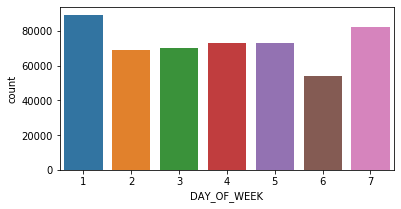

In [6]:
%matplotlib inline
plt.figure(figsize=(6, 3))

sns.countplot(airline["DAY_OF_WEEK"])

In [7]:
# 1. 刪除沒有天氣數據的出發地、目的地航班資料(列)

no_weather_data_o = airline[((airline['ORIGIN'] != "DAL") & (airline['ORIGIN'] != "HOU")
              & (airline['ORIGIN'] != "BNA") & (airline['ORIGIN'] != "STL"))]

airlines = airline.drop(no_weather_data_o.index)

no_weather_data_d = airlines[((airlines['DEST'] != "DAL") & (airlines['DEST'] != "HOU")
              & (airlines["DEST"] != "BNA") & (airlines['DEST'] != "STL"))]


airline = airlines.drop(no_weather_data_d.index)

print(airline.shape)

(2376, 28)


In [8]:
# 2. 刪除用不到的欄位
airline.drop(['UNIQUE_CARRIER','FL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','ORIGIN_STATE_ABR'
              ,'DEST_STATE_ABR',"Unnamed: 27"],axis=1,inplace=True)

# 3. 將DEP_TIME、DEP_DELAY、ARR_TIME、ARR_DELAY、ACTUAL_ELAPSED_TIME、AIR_TIME這些特徵有缺失值的資料整筆刪除
airline.dropna(subset=["DEP_TIME","DEP_DELAY","ARR_TIME","ARR_DELAY","ACTUAL_ELAPSED_TIME"
                       ,"AIR_TIME"],inplace=True)
print(airline.shape)

(2354, 21)


In [9]:
airline.isnull().sum()

YEAR                      0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
ORIGIN                    0
DEST                      0
CRS_DEP_TIME              0
DEP_TIME                  0
DEP_DELAY                 0
CRS_ARR_TIME              0
ARR_TIME                  0
ARR_DELAY                 0
CRS_ELAPSED_TIME          0
ACTUAL_ELAPSED_TIME       0
AIR_TIME                  0
DISTANCE                  0
CARRIER_DELAY          1899
WEATHER_DELAY          1899
NAS_DELAY              1899
SECURITY_DELAY         1899
LATE_AIRCRAFT_DELAY    1899
dtype: int64

In [10]:
# 4. 將延誤原因與"天氣"無關的航班資料刪除(先抓)
not_weather_delay = airline[((airline['CARRIER_DELAY'] >= 0) | (airline['LATE_AIRCRAFT_DELAY'] >= 0)
              | (airline['NAS_DELAY'] >= 0) |(airline['SECURITY_DELAY'] >= 0))
              & (airline['WEATHER_DELAY'] == 0) ]

len(not_weather_delay) #延誤原因與"天氣"無關的航班資料數為439筆

439

In [11]:
# 4. 將延誤原因與"天氣"無關的航班資料刪除(再刪)
flight = airline.drop(not_weather_delay.index)
print(flight.shape) ##因天氣延誤&正常飛行的資料筆數為1915

(1915, 21)


In [12]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1915 entries, 233164 to 337397
Data columns (total 21 columns):
YEAR                   1915 non-null int64
MONTH                  1915 non-null int64
DAY_OF_MONTH           1915 non-null int64
DAY_OF_WEEK            1915 non-null int64
ORIGIN                 1915 non-null object
DEST                   1915 non-null object
CRS_DEP_TIME           1915 non-null int64
DEP_TIME               1915 non-null float64
DEP_DELAY              1915 non-null float64
CRS_ARR_TIME           1915 non-null int64
ARR_TIME               1915 non-null float64
ARR_DELAY              1915 non-null float64
CRS_ELAPSED_TIME       1915 non-null float64
ACTUAL_ELAPSED_TIME    1915 non-null float64
AIR_TIME               1915 non-null float64
DISTANCE               1915 non-null float64
CARRIER_DELAY          16 non-null float64
WEATHER_DELAY          16 non-null float64
NAS_DELAY              16 non-null float64
SECURITY_DELAY         16 non-null float64
LATE_AIR

In [13]:
flight.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,...,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
233164,2013,9,1,7,BNA,HOU,1830,1845.0,15.0,2025,...,7.0,115.0,107.0,93.0,670.0,NaN,NaN,NaN,NaN,NaN
233165,2013,9,1,7,BNA,HOU,840,840.0,0.0,1035,...,-10.0,115.0,105.0,90.0,670.0,NaN,NaN,NaN,NaN,NaN
233166,2013,9,1,7,BNA,HOU,1000,958.0,-2.0,1155,...,-11.0,115.0,106.0,93.0,670.0,NaN,NaN,NaN,NaN,NaN
233192,2013,9,1,7,BNA,STL,1545,1542.0,-3.0,1650,...,-14.0,65.0,54.0,44.0,272.0,NaN,NaN,NaN,NaN,NaN
233453,2013,9,1,7,DAL,HOU,1100,1100.0,0.0,1200,...,-5.0,60.0,55.0,40.0,239.0,NaN,NaN,NaN,NaN,NaN


### 分析數據: ARR_DELAY<=0，WEATHER_DELAY應將空值補為0 ; 0<ARR_DELAY<=15，不會標註延誤原因為何以及對應的延誤分鐘數 ; ARR_DELAY>15會標記，無須進行額外處理

In [14]:
## 6. WEATHER_DELAY補值

# 先將ARR_DELAY<=0的資料中，WEATHER_DELAY補0

# 抓出ARR_DELAY<=0的資料(列)
on_time = flight[flight['ARR_DELAY']<=0] 

# 由於ARR_DELAY<=0為準時，因此WEATHER_DELAY分鐘數應該改填0
for col in ["WEATHER_DELAY"]:
    on_time[col] = on_time[col].fillna(0)

# 把原先完整的df中先移除ARR_DELAY<=0的資料(列)
flight = flight.drop(on_time.index)


flights = pd.concat([flight,on_time],axis=0)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
## 7. WEATHER_DELAY補值

# 使用knn填補WEATHER_DELAY的空值

train_y1 = flights[flights["WEATHER_DELAY"].isnull().values==False]["WEATHER_DELAY"]
train_x1 = flights[flights["WEATHER_DELAY"].isnull().values==False].loc[:,["DAY_OF_MONTH","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE"]]

test_x1 = flights[flights["WEATHER_DELAY"].isnull().values==True].loc[:,["DAY_OF_MONTH","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE"]]

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
 
def knn_missing_filled(x_train, y_train, test, k = 3, dispersed = True):
    if dispersed:
        clf = KNeighborsClassifier(n_neighbors = k, weights = "distance")
    else:
        clf = KNeighborsRegressor(n_neighbors = k, weights = "distance")
    
    clf.fit(x_train, y_train)
    return test.index, clf.predict(test)

##########################################之後看score如何，調整k值###################################

index,pred = knn_missing_filled(train_x1,train_y1,test_x1,k=8, dispersed = False) #WEATHER_DELAY為連續型資料
index,pred

(Int64Index([233164, 233504, 233742, 233743, 233746, 233750, 233751, 237347,
             237374, 237375,
             ...
             336666, 336668, 336670, 336673, 336731, 336733, 336738, 337392,
             337393, 337395],
            dtype='int64', length=710),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        2.27481967, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.87345908, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.00861923, 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.22893361,
        0.        , 0.        , 0.        , 0.    

In [16]:
## 7. WEATHER_DELAY補值
flights.loc[index,"WEATHER_DELAY"] = pred
flights

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,...,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
233164,2013,9,1,7,BNA,HOU,1830,1845.0,15.0,2025,...,7.0,115.0,107.0,93.0,670.0,NaN,0.0,NaN,NaN,NaN
233504,2013,9,1,7,DAL,STL,1300,1309.0,9.0,1440,...,4.0,100.0,95.0,82.0,546.0,NaN,0.0,NaN,NaN,NaN
233742,2013,9,1,7,HOU,DAL,1230,1231.0,1.0,1325,...,1.0,55.0,55.0,44.0,239.0,NaN,0.0,NaN,NaN,NaN
233743,2013,9,1,7,HOU,DAL,1430,1436.0,6.0,1525,...,4.0,55.0,53.0,42.0,239.0,NaN,0.0,NaN,NaN,NaN
233746,2013,9,1,7,HOU,DAL,1100,1100.0,0.0,1155,...,8.0,55.0,63.0,43.0,239.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337379,2013,9,24,2,STL,BNA,1810,1808.0,-2.0,1910,...,-4.0,60.0,58.0,42.0,272.0,NaN,0.0,NaN,NaN,NaN
337389,2013,9,24,2,STL,DAL,1650,1658.0,8.0,1835,...,-9.0,105.0,88.0,76.0,546.0,NaN,0.0,NaN,NaN,NaN
337391,2013,9,24,2,STL,DAL,1350,1348.0,-2.0,1520,...,-1.0,90.0,91.0,77.0,546.0,NaN,0.0,NaN,NaN,NaN
337396,2013,9,24,2,STL,DAL,640,637.0,-3.0,815,...,-4.0,95.0,94.0,78.0,546.0,NaN,0.0,NaN,NaN,NaN


In [17]:
# 新增名為weather_delay_TF的欄位紀錄此航班是否因天氣而延誤
flights["weather_delay_TF"] = np.where(flights['WEATHER_DELAY']>0,1,0)

In [18]:
## 8. 切割時間
## 時間格式(hhmm)，長度<=2 --> 0時 ; 長度=3:取前一碼;長度=4:取前兩碼

# 出發(時):CRS_DEP_TIME
flights["DEP_HOUR"] = flights["CRS_DEP_TIME"].apply(lambda x:0 if len(str(x))<=2 else int(str(x)[:1]) if len(str(x))==3 else int(str(x)[:2]))
# 抵達(時):ARR_TIME
flights["ARR_HOUR"] = flights["ARR_TIME"].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
flights["ARR_HOUR"] = flights["ARR_HOUR"].apply(lambda x:0 if x==24 else x)

In [19]:
# ## 9. 將月日合併一個新日期欄位

# # 將DAY_OF_MONTH補齊成兩位數
# flights["day"] = flights["DAY_OF_MONTH"].apply(lambda x : str(x).zfill(2) if int(x)<31 else 0)

# # 將DAY_OF_MONTH和MONTH合併成 月日 格式
# flights["Month_Day"] = flights["MONTH"].map(str)+flights["day"].map(str)

# # 對合併過後的新欄位DAY_MERGE排序 
# flights["Month_Day"] = flights["Month_Day"].apply(lambda x : int(x) if x != 0 else 0)
# flights["Month_Day"] = flights["Month_Day"].sort_values()

# # 將day欄位刪除(因為已經產出DAY_MERGE了)
# flights.drop(['day'],axis=1,inplace=True)

In [20]:
# 9. 為了和天氣資料比對，統一日期欄位名稱:Day
flights.rename(columns={'DAY_OF_MONTH':'Day'},inplace=True)

In [21]:
# 10. 刪除延誤原因不為天氣的延誤原因欄位

## 最後確認刪除用不到的欄位(因航班data都為2013/09，因此年、月欄位不影響判斷，可以刪除)
## 已新增Month_Day欄位-->刪除DAY_OF_MONTH
## 因本次主要要探討的是"天氣"對航班是否會造成延誤，因此把與"天氣"無關的延誤原因欄位刪除)

flights.drop(["YEAR","MONTH","DAY_OF_WEEK","CARRIER_DELAY","NAS_DELAY"
                        ,"SECURITY_DELAY","LATE_AIRCRAFT_DELAY"],axis=1,inplace=True)

In [22]:
flights

,Day,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,WEATHER_DELAY,weather_delay_TF,DEP_HOUR,ARR_HOUR
233164,1,BNA,HOU,1830,1845.0,15.0,2025,2032.0,7.0,115.0,107.0,93.0,670.0,0.0,0,18,20
233504,1,DAL,STL,1300,1309.0,9.0,1440,1444.0,4.0,100.0,95.0,82.0,546.0,0.0,0,13,14
233742,1,HOU,DAL,1230,1231.0,1.0,1325,1326.0,1.0,55.0,55.0,44.0,239.0,0.0,0,12,13
233743,1,HOU,DAL,1430,1436.0,6.0,1525,1529.0,4.0,55.0,53.0,42.0,239.0,0.0,0,14,15
233746,1,HOU,DAL,1100,1100.0,0.0,1155,1203.0,8.0,55.0,63.0,43.0,239.0,0.0,0,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337379,24,STL,BNA,1810,1808.0,-2.0,1910,1906.0,-4.0,60.0,58.0,42.0,272.0,0.0,0,18,19
337389,24,STL,DAL,1650,1658.0,8.0,1835,1826.0,-9.0,105.0,88.0,76.0,546.0,0.0,0,16,18
337391,24,STL,DAL,1350,1348.0,-2.0,1520,1519.0,-1.0,90.0,91.0,77.0,546.0,0.0,0,13,15
337396,24,STL,DAL,640,637.0,-3.0,815,811.0,-4.0,95.0,94.0,78.0,546.0,0.0,0,6,8


In [23]:
flights.to_csv("C:/Users/USER/Desktop/airlines.csv",index=False)

#### 查看類別比例，發現資料unbalance

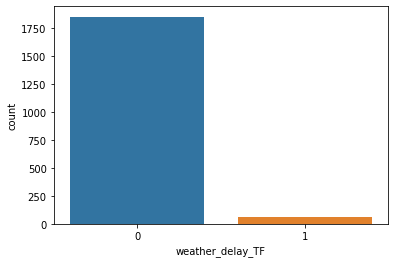

In [24]:
#第一階段target
%matplotlib inline

sns.countplot(flights["weather_delay_TF"])

In [25]:
flights["weather_delay_TF"].value_counts()#查看各類別資料筆數 0 : 1871 ; 1 : 44

0    1852
1      63
Name: weather_delay_TF, dtype: int64

#### 分別查看4個機場延誤狀況

In [26]:
#出發地機場

O_carrier_delay = pd.DataFrame()

for AP in list(flights['ORIGIN'].unique()):
    perc_delayed = len(flights[(flights['ORIGIN']==AP) & (flights['WEATHER_DELAY']>=5)].index)/len(flights[flights['ORIGIN']==AP].index)*100
    O_carrier_delay = O_carrier_delay.append({'ORIGIN':AP,'percent_delayed' : perc_delayed},ignore_index=True)

O_carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)

# 目的地機場
D_carrier_delay = pd.DataFrame()

for AP in list(flights['DEST'].unique()):
    perc_delayed = len(flights[(flights['DEST']==AP) & (flights['WEATHER_DELAY']>=5)].index)/len(flights[flights['DEST']==AP].index)*100
    D_carrier_delay = D_carrier_delay.append({'DEST':AP,'percent_delayed' : perc_delayed},ignore_index=True)

D_carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)

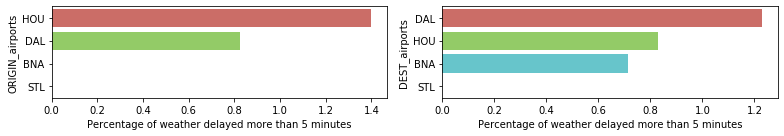

In [27]:
plt.figure(figsize=(11, 2))

plt.subplot(1,2,1) #一列兩行的第一張圖

color_pal = sns.color_palette("cubehelix", len(O_carrier_delay.index))
color_pal = color_pal[::-1]

g = sns.barplot(x="percent_delayed", y="ORIGIN", data=O_carrier_delay,palette="hls")
g.set_ylabel('ORIGIN_airports')
g.set_xlabel('Percentage of weather delayed more than 5 minutes')
fig = g.get_figure()


plt.subplot(1,2,2) #一列兩行的第二張圖
color_pal = sns.color_palette("cubehelix", len(D_carrier_delay.index))
color_pal = color_pal[::-1]

g = sns.barplot(x="percent_delayed", y="DEST", data=D_carrier_delay,palette="hls")
g.set_ylabel('DEST_airports')
g.set_xlabel('Percentage of weather delayed more than 5 minutes')
fig = g.get_figure()

plt.tight_layout()

### 合併航班天氣資料，分為兩部分: 1. 預測是否會因天氣延誤(二元分類問題) 2. 若因天氣延誤，則延誤多久(回歸問題)

1.預測航班是否會因為天氣因素而延遲
    
* 為二元分類問題
* 天氣data中需要用到的延遲欄位為:weather_delay_TF
* 由於延遲與沒延遲的資料數差距大，資料呈現unbalance，因此之後在看績效指標時，不用accuracy，而是選擇F1-mesure當作判斷標準

* 模型:Logistic迴歸、決策樹、RF、SVM、KNN
    
2.若延遲，則延遲多久
    
* 為迴歸問題
* 天氣data中需要用到的延遲欄位為:WEATHER_DELAY > 0 的列

In [28]:
# load weather and airlines data

weather = pd.read_csv(r"C:\Users\USER\Desktop\weather.csv")
airlines = pd.read_csv("C:/Users/USER/Desktop/airlines.csv")

In [29]:
airlines1 = airlines.copy()
airlines2 = airlines.copy()
del airlines

airlines1.drop(["WEATHER_DELAY"],axis=1,inplace=True)

# 挑出WEATHER_DELAY = 0的列
no_delay = airlines2[(airlines2["WEATHER_DELAY"]==0)]
airlines2 = airlines2.drop(no_delay.index) 
airlines2.drop(["weather_delay_TF"],axis=1,inplace=True)

In [30]:
print(airlines1.shape)
print(airlines2.shape)

(1915, 16)
(63, 16)


In [31]:
weather

,STATION_NAME,HOURLYVISIBILITY,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYPrecip,TIME,Day,HOUR,evaporation
0,STL,10.0,23.3,77.0,6.0,0.0,00:51,1,0,3.3
1,STL,10.0,23.3,82.0,0.0,0.0,01:51,1,1,2.5
2,STL,10.0,23.3,87.0,5.0,0.0,02:51,1,2,1.8
3,STL,8.0,23.3,90.0,3.0,0.0,03:51,1,3,1.3
4,STL,9.0,23.3,87.0,0.0,0.0,04:51,1,4,1.8
...,...,...,...,...,...,...,...,...,...,...
2875,DAL,10.0,15.0,50.0,3.0,0.0,19:53,30,19,5.6
2876,DAL,10.0,16.1,58.0,6.0,0.0,20:53,30,20,4.9
2877,DAL,10.0,16.7,62.0,7.0,0.0,21:53,30,21,4.5
2878,DAL,10.0,16.7,62.0,7.0,0.0,22:53,30,22,4.5


In [32]:
weather.drop(["TIME"],axis=1,inplace=True)

weather_origin = weather.copy()
weather_dest = weather.copy()

# 出發地
weather_origin.rename(index=str, columns={"STATION_NAME": "ORIGIN"},inplace=True)
weather_origin.rename(index=str, columns={"HOURLYVISIBILITY": "DEP_HOURLYVISIBILITY"},inplace=True)
weather_origin.rename(index=str, columns={"HOURLYDewPointTempC": "DEP_HOURLYDewPointTempC"},inplace=True)
weather_origin.rename(index=str, columns={"HOURLYRelativeHumidity": "DEP_HOURLYRelativeHumidity"},inplace=True)
weather_origin.rename(index=str, columns={"HOURLYWindSpeed": "DEP_HOURLYWindSpeed"},inplace=True)
weather_origin.rename(index=str, columns={"HOURLYPrecip": "DEP_HOURLYPrecip"},inplace=True)
weather_origin.rename(index=str, columns={"evaporation": "DEP_evaporation"},inplace=True)
weather_origin.rename(index=str, columns={"HOUR": "DEP_HOUR"},inplace=True)

# 目的地
weather_dest.rename(index=str, columns={"STATION_NAME": "DEST"},inplace=True)
weather_dest.rename(index=str, columns={"HOURLYVISIBILITY": "ARR_HOURLYVISIBILITY"},inplace=True)
weather_dest.rename(index=str, columns={"HOURLYDewPointTempC": "ARR_HOURLYDewPointTempC"},inplace=True)
weather_dest.rename(index=str, columns={"HOURLYRelativeHumidity": "ARR_HOURLYRelativeHumidity"},inplace=True)
weather_dest.rename(index=str, columns={"HOURLYWindSpeed": "ARR_HOURLYWindSpeed"},inplace=True)
weather_dest.rename(index=str, columns={"HOURLYPrecip": "ARR_HOURLYPrecip"},inplace=True)
weather_dest.rename(index=str, columns={"evaporation": "ARR_evaporation"},inplace=True)
weather_dest.rename(index=str, columns={"HOUR": "ARR_HOUR"},inplace=True)

In [33]:
# airlines1
# 以航班資料為主(how='left')，合併每個航班的出發地、目的地天氣 
airlines1 = pd.merge(airlines1, weather_origin, on=['ORIGIN','Day','DEP_HOUR'], how='left')
airlines1 = pd.merge(airlines1, weather_dest, on=['DEST','Day','ARR_HOUR'], how='left')

In [34]:
# airlines2
# 以航班資料為主(how='left')，合併每個航班的出發地、目的地天氣 
airlines2 = pd.merge(airlines2, weather_origin, on=['ORIGIN','Day','DEP_HOUR'], how='left')
airlines2 = pd.merge(airlines2, weather_dest, on=['DEST','Day','ARR_HOUR'], how='left')

In [35]:
airlines1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1915 entries, 0 to 1914
Data columns (total 28 columns):
Day                           1915 non-null int64
ORIGIN                        1915 non-null object
DEST                          1915 non-null object
CRS_DEP_TIME                  1915 non-null int64
DEP_TIME                      1915 non-null float64
DEP_DELAY                     1915 non-null float64
CRS_ARR_TIME                  1915 non-null int64
ARR_TIME                      1915 non-null float64
ARR_DELAY                     1915 non-null float64
CRS_ELAPSED_TIME              1915 non-null float64
ACTUAL_ELAPSED_TIME           1915 non-null float64
AIR_TIME                      1915 non-null float64
DISTANCE                      1915 non-null float64
weather_delay_TF              1915 non-null int64
DEP_HOUR                      1915 non-null int64
ARR_HOUR                      1915 non-null int64
DEP_HOURLYVISIBILITY          1915 non-null float64
DEP_HOURLYDewPointTempC

In [36]:
airlines2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 28 columns):
Day                           63 non-null int64
ORIGIN                        63 non-null object
DEST                          63 non-null object
CRS_DEP_TIME                  63 non-null int64
DEP_TIME                      63 non-null float64
DEP_DELAY                     63 non-null float64
CRS_ARR_TIME                  63 non-null int64
ARR_TIME                      63 non-null float64
ARR_DELAY                     63 non-null float64
CRS_ELAPSED_TIME              63 non-null float64
ACTUAL_ELAPSED_TIME           63 non-null float64
AIR_TIME                      63 non-null float64
DISTANCE                      63 non-null float64
WEATHER_DELAY                 63 non-null float64
DEP_HOUR                      63 non-null int64
ARR_HOUR                      63 non-null int64
DEP_HOURLYVISIBILITY          63 non-null float64
DEP_HOURLYDewPointTempC       63 non-null float64
DEP_HOURL

In [37]:
# 匯出合併後的檔案
airlines1.to_csv("C:/Users/USER/Desktop/firstphase_test.csv",index=False)
airlines2.to_csv("C:/Users/USER/Desktop/secondphase_test.csv",index=False)

In [38]:
# load data
df1 = pd.read_csv("C:/Users/USER/Desktop/firstphase_test.csv")
df2 = pd.read_csv("C:/Users/USER/Desktop/secondphase_test.csv")

In [39]:
# 1. 查看總體資料
print("第一階段資料:",df1.shape)
print("第二階段資料:",df2.shape)

第一階段資料: (1915, 28)
第二階段資料: (63, 28)
